<a href="https://colab.research.google.com/github/palswayam5/Low-Light-Enhancement/blob/main/ZERO_DCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Input,Conv2D,Concatenate
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
MAX_TRAIN_IMAGES = 400

PRE_REQUISITE FUNCTION TO GENERATE DATA FROM FOLDERS

In [4]:
def load_data(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(images=img, size=[IMAGE_SIZE, IMAGE_SIZE])
    img = img / 255.0  #scaling between [0,1]
    return img

In [5]:
def data_generator(low_light_images):
    data = tf.data.Dataset.from_tensor_slices((low_light_images))
    data = data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.batch(BATCH_SIZE, drop_remainder=True)
    return data

DATASET PREPARATION

In [6]:
train_low_light_images = sorted(glob("/content/drive/MyDrive/lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/drive/MyDrive/lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("/content/drive/MyDrive/lol_dataset/eval15/low/*"))
test_high_light_images = sorted(glob("/content/drive/MyDrive/lol_dataset/eval15/high/*"))


train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>


In [7]:
def Build_DCE_NET():
    input_img = Input(shape=[None, None, 3])
    x1 = Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(input_img)
    x2 = Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(x1)
    x3 = Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(x2)
    x4 = Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(x3)

    int_x1 = Concatenate(axis=-1)([x4, x3])
    x5 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(int_x1)

    int_x2 = Concatenate(axis=-1)([x5, x2])
    x6 = Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(int_x2)

    int_x3 = Concatenate(axis=-1)([x6, x1])
    y = Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(int_x3)

    return Model(inputs=input_img, outputs=y)

In [8]:
model = Build_DCE_NET()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 32)       9248      ['conv2d_1[0][0]']            
                                                                                              

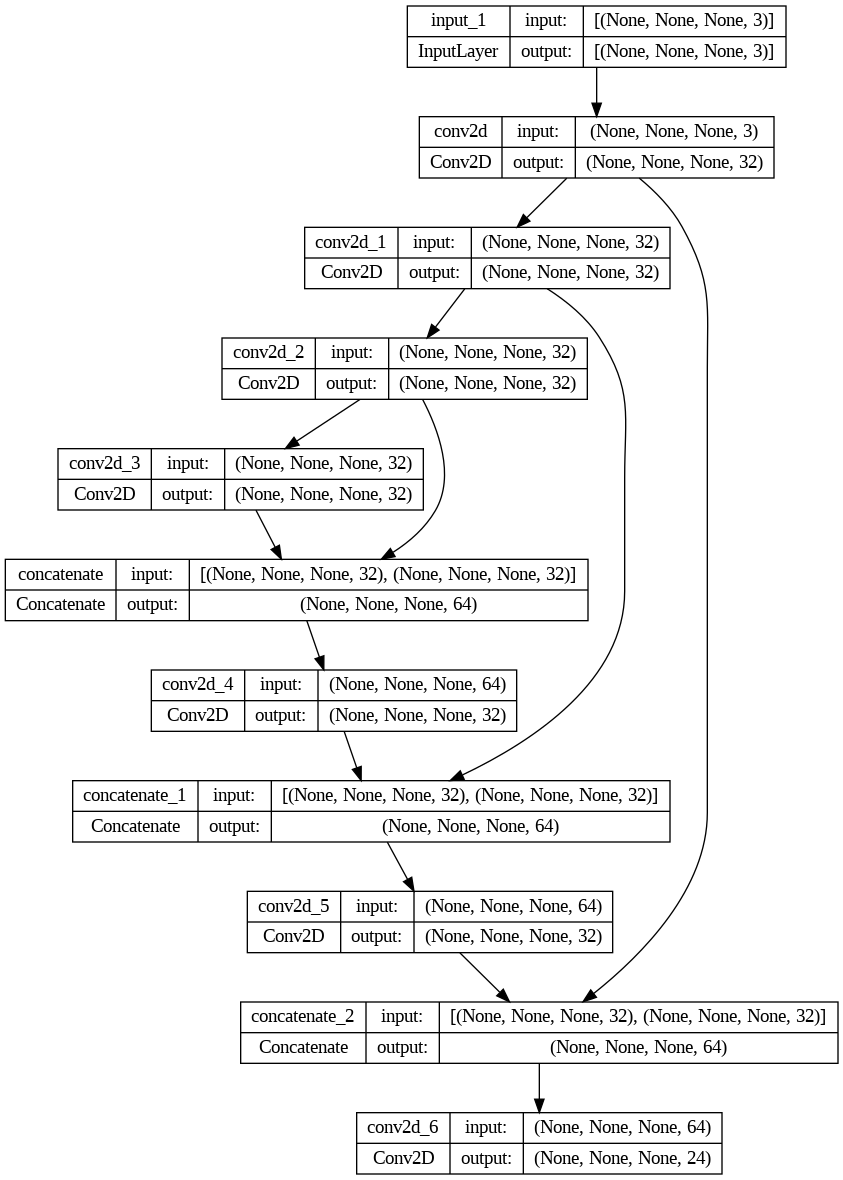

In [9]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

CUSTOM LOSS FUNCTIONS

In [10]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    jr, jg, jb = (
        mean_rgb[:, :, :, 0],
        mean_rgb[:, :, :, 1],
        mean_rgb[:, :, :, 2],
    )
    #ji denotes average intensity of ith channel
    #pairwise taking squares
    diff_rg = tf.square(jr - jg)
    diff_rb = tf.square(jr - jb)
    diff_gb = tf.square(jb - jg)

    L_col = tf.sqrt(tf.square(diff_rg) + tf.square(diff_rb) + tf.square(diff_gb))
    return  L_col

In [11]:
def exposure_loss(x, E=0.6):  # E is the grey level in RGB color generally taken as 0.6 for experiments
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID") #averaging over 16x16 non-overlapping regions
    L_exp = tf.reduce_mean(tf.square(mean - E)) #took the mean of all the values
    return L_exp

In [12]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (w_x - 1) * tf.shape(x)[3]
    count_w = w_x * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

CUSTOM ZERO DCE MODEL ----> MODIFYING IT'S Properties

In [13]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = Build_DCE_NET()

    #custom compile function to accomadate custom loss functions
    def compile(self, learning_rate, **kwargs):
        super().compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        #self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.illumination_smoothness_loss_tracker = keras.metrics.Mean(name="illumination_smoothness_loss")
        self.color_constancy_loss_tracker = keras.metrics.Mean(name="color_constancy_loss")
        self.exposure_loss_tracker = keras.metrics.Mean(name="exposure_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.illumination_smoothness_loss_tracker,
            self.color_constancy_loss_tracker,
            self.exposure_loss_tracker,
        ]

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    #lossed are calcualted by multiplying them with their corrosponding weights
    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        #loss_spatial_constancy = tf.reduce_mean(
            #self.spatial_constancy_loss(enhanced_image, data)
        #)
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (loss_illumination+ loss_color_constancy+ loss_exposure)

        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)

        gradients = tape.gradient(losses["total_loss"], self.dce_model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights)) #weights are updated accroding to the gradients

        #every loss is updated
        self.total_loss_tracker.update_state(losses["total_loss"]) #total loss status updated
        self.illumination_smoothness_loss_tracker.update_state(losses["illumination_smoothness_loss"])
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def test_step(self, data):
        output = self.dce_model(data)
        losses = self.compute_losses(data, output)

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

In [14]:
def plot(images,titles,figure_size = (10,10)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _fig = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [15]:
def calculate_psnr(original_image, enhanced_image):
  # Convert the images to numpy arrays.
  original_image = np.array(original_image)
  enhanced_image = np.array(enhanced_image)
  # Calculate the mean squared error (MSE) between the two images.
  mse = np.mean((original_image - enhanced_image) ** 2)
  # Calculate the peak signal-to-noise ratio (PSNR).
  psnr = 10 * np.log10(255 ** 2 / mse)
  return psnr

In [16]:
Image_Enhancer = ZeroDCE()
Image_Enhancer.compile(learning_rate = 1e-4)
Image_Enhancer.fit(train_dataset,validation_data=val_dataset,epochs=50)

Epoch 1/50
12/12 [==============================] - 37s 1s/step - total_loss: 5.6961 - illumination_smoothness_loss: 2.7345 - color_constancy_loss: 0.0029 - exposure_loss: 2.9588 - val_total_loss: 6.8222 - val_illumination_smoothness_loss: 3.8801 - val_color_constancy_loss: 0.0025 - val_exposure_loss: 2.9396
Epoch 2/50
12/12 [==============================] - 7s 544ms/step - total_loss: 4.9228 - illumination_smoothness_loss: 1.9747 - color_constancy_loss: 0.0027 - exposure_loss: 2.9455 - val_total_loss: 5.9080 - val_illumination_smoothness_loss: 2.9765 - val_color_constancy_loss: 0.0025 - val_exposure_loss: 2.9291
Epoch 3/50
12/12 [==============================] - 7s 539ms/step - total_loss: 4.4532 - illumination_smoothness_loss: 1.5135 - color_constancy_loss: 0.0027 - exposure_loss: 2.9370 - val_total_loss: 5.3132 - val_illumination_smoothness_loss: 2.3887 - val_color_constancy_loss: 0.0026 - val_exposure_loss: 2.9219
Epoch 4/50
12/12 [==============================] - 7s 583ms/step 

In [17]:
def low_to_high_light(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = Image_Enhancer(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

Displaying Results for 5 images

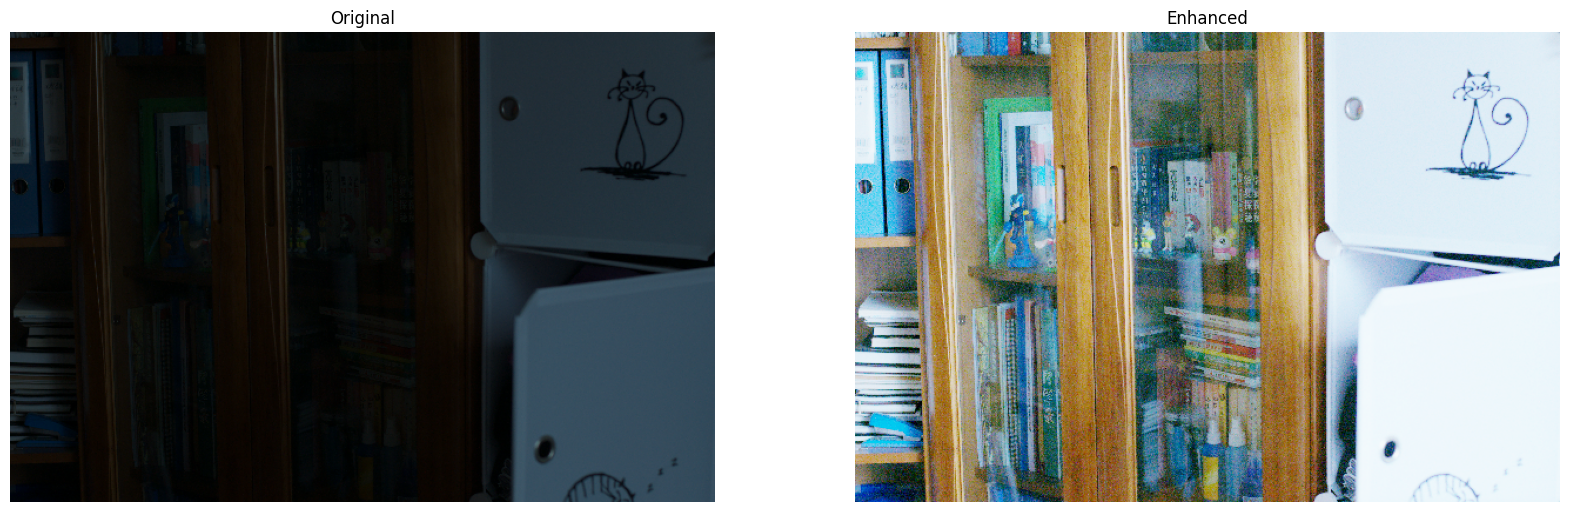

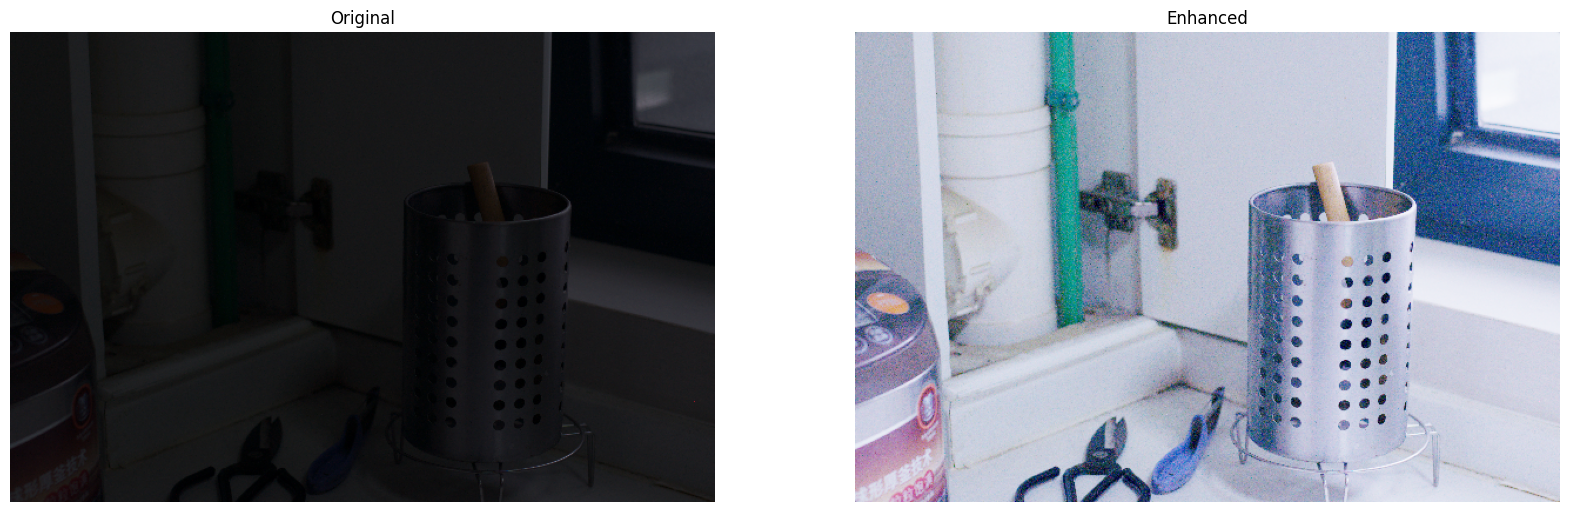

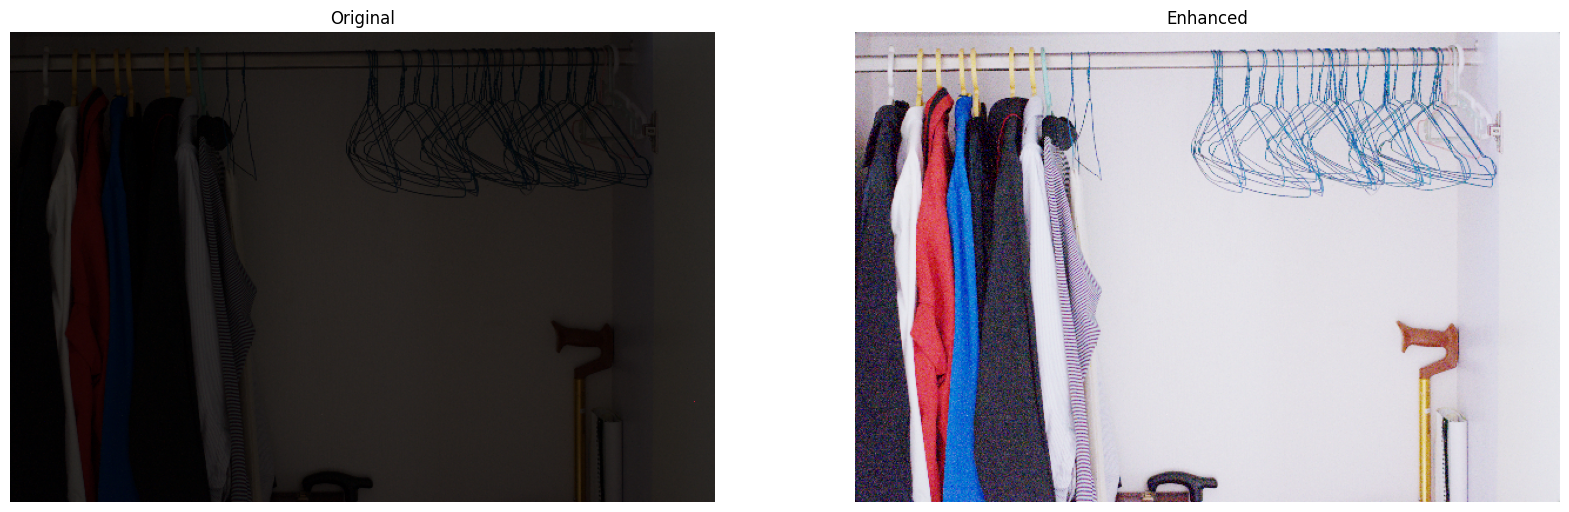

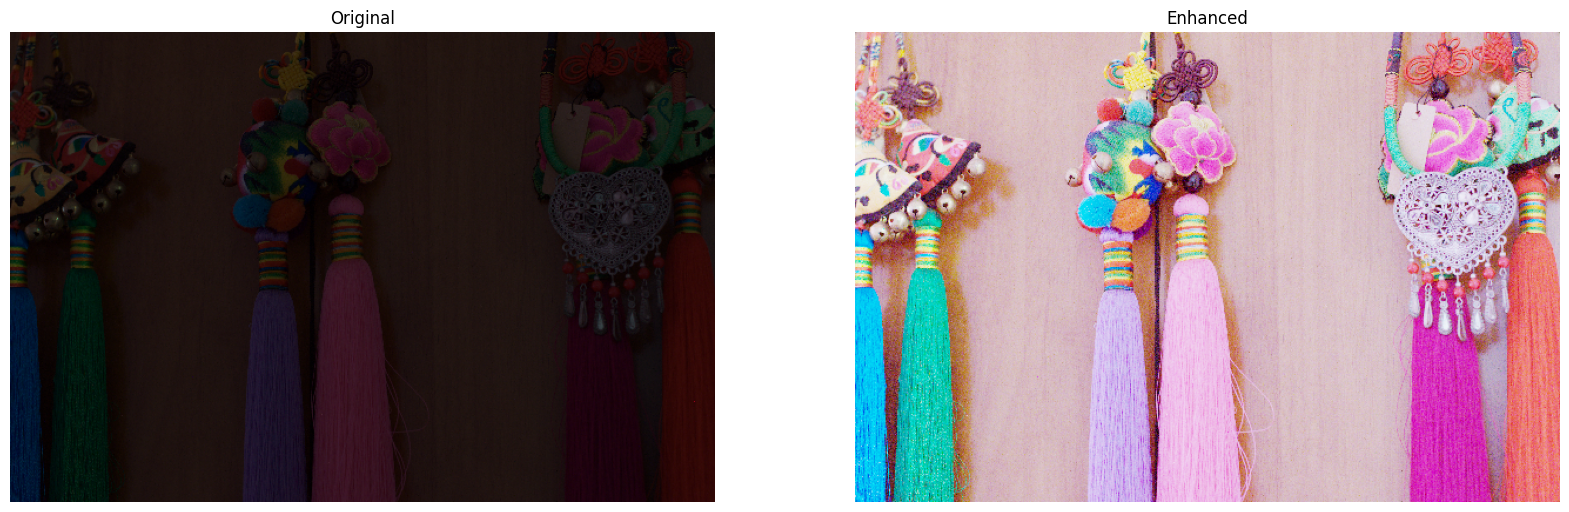

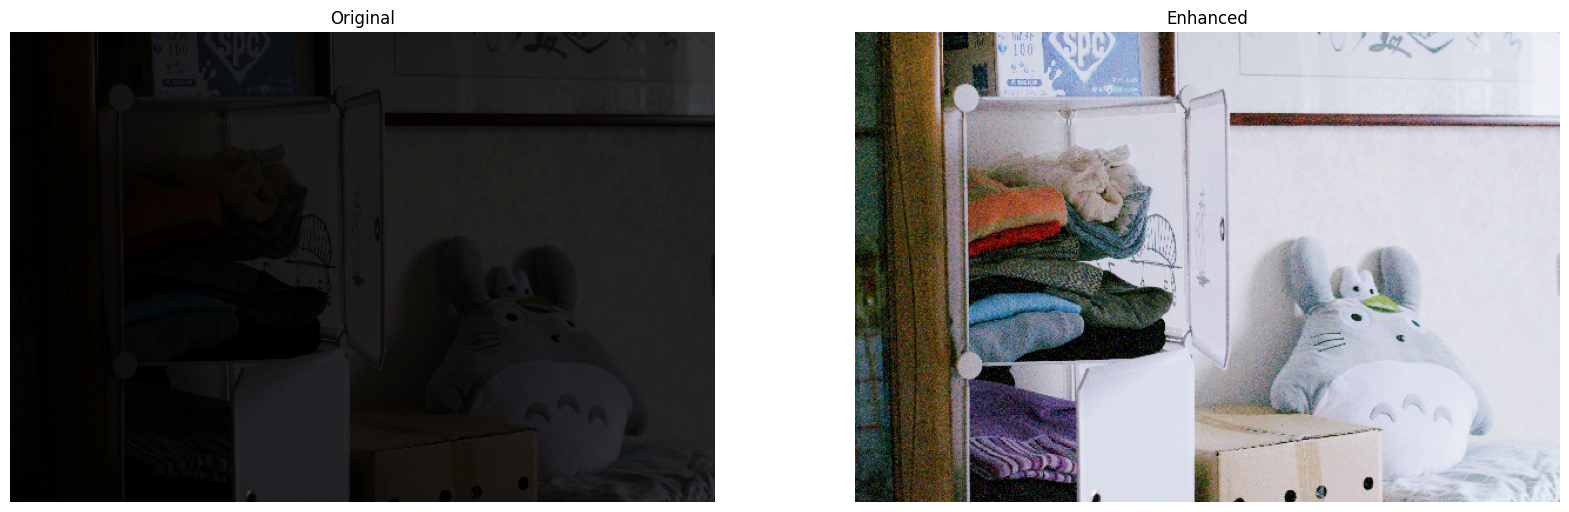

In [18]:
for val_image_file in test_low_light_images[:5]:
    original_image = Image.open(val_image_file)
    enhanced_image = low_to_high_light(original_image)
    plot(
        [original_image,enhanced_image],
        ["Original","Enhanced"],
        (20, 12),
    )

In [21]:
psnr_ratio = []
for i in range(len(test_low_light_images)):
    low_light_image = Image.open(test_low_light_images[i])
    enhanced_image = low_to_high_light(low_light_image)
    high_light_image = Image.open(test_high_light_images[i])
    psnr = calculate_psnr(high_light_image, enhanced_image)
    psnr_ratio.append(psnr)
    #print(f"PSNR for {test_low_light_images[i]}: {psnr}")

In [22]:
np.average(psnr_ratio)

27.842776326829405